In [1]:
from pandas import read_csv
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
import matplotlib.pyplot as plt
import math
import numpy as np

import data

In [2]:
# X_train = read_csv('../X_train_nostring.csv')
# X_train.fillna(-3, inplace=True)
# X_train = X_train.values[:,1:]

y_train_data = read_csv('../y_train.csv')
y_train = y_train_data.values[:,1]
for i in range(len(y_train)):
    if y_train[i] == -1:
        y_train[i] = 0

# scaler = StandardScaler()

# X_train = scaler.fit_transform(X_train, y_train)

In [3]:
# X_test_data = read_csv('../X_test_nostring.csv')
# X_test_data.fillna(-3, inplace=True)
# X_test = X_test_data.values[:,1:]

# X_test = scaler.fit_transform(X_test)

In [4]:
dataset = data.Dataset()
X_train = dataset.getTrain().values
X_test = dataset.getTest().values

In [5]:
# grid search
model = xgb.XGBClassifier(objective="multi:softmax", subsample=0.5, random_state=441)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=441)

#-0.851461 for 62, 0.1 with data one hot
#-0.853006 for 62, 0.1 is min seems
#Best: -0.849549 using {'learning_rate': 0.1, 'max_depth': 10, 'max_leaves': 66, 'subsample': 0.7}
#Best: -0.848820 using {'learning_rate': 0.1, 'max_depth': 8, 'max_leaves': 66, 'subsample': 0.8}
param_grid = {
    'max_depth': [6, 8, 10],
    'max_leaves': [66],
    'learning_rate': [0.1],#[0.5, 0.1, 0.05]
    'subsample': [0.8]
}

grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)

# print results
means = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
for mean, param in zip(means, params):
 print("%f with: %r" % (mean, param))

print("\nBest: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

-0.849928 with: {'learning_rate': 0.1, 'max_depth': 8, 'max_leaves': 64, 'subsample': 0.7}
-0.849382 with: {'learning_rate': 0.1, 'max_depth': 8, 'max_leaves': 64, 'subsample': 0.8}
-0.849669 with: {'learning_rate': 0.1, 'max_depth': 8, 'max_leaves': 66, 'subsample': 0.7}
-0.848820 with: {'learning_rate': 0.1, 'max_depth': 8, 'max_leaves': 66, 'subsample': 0.8}
-0.850210 with: {'learning_rate': 0.1, 'max_depth': 8, 'max_leaves': 68, 'subsample': 0.7}
-0.849302 with: {'learning_rate': 0.1, 'max_depth': 8, 'max_leaves': 68, 'subsample': 0.8}
-0.850435 with: {'learning_rate': 0.1, 'max_depth': 10, 'max_leaves': 64, 'subsample': 0.7}
-0.849314 with: {'learning_rate': 0.1, 'max_depth': 10, 'max_leaves': 64, 'subsample': 0.8}
-0.849549 with: {'learning_rate': 0.1, 'max_depth': 10, 'max_leaves': 66, 'subsample': 0.7}
-0.848899 with: {'learning_rate': 0.1, 'max_depth': 10, 'max_leaves': 66, 'subsample': 0.8}
-0.848952 with: {'learning_rate': 0.1, 'max_depth': 10, 'max_leaves': 68, 'subsample':

In [9]:
best_model = xgb.XGBClassifier(objective="multi:softmax", random_state=441, max_depth=8, max_leaves=66, learning_rate=0.1, subsample=0.8).fit(X_train, y_train)
prob = best_model.predict_proba(X_test)

In [10]:
test = np.c_[ np.ones(11438), prob ]              # add a column

for i in range(len(test)):
    test[i][0] = i

np.savetxt('xgb.csv', test, delimiter=',', header="id,no answer,very important,quite important,not important,not at all important", comments="", fmt='%1.4f') 

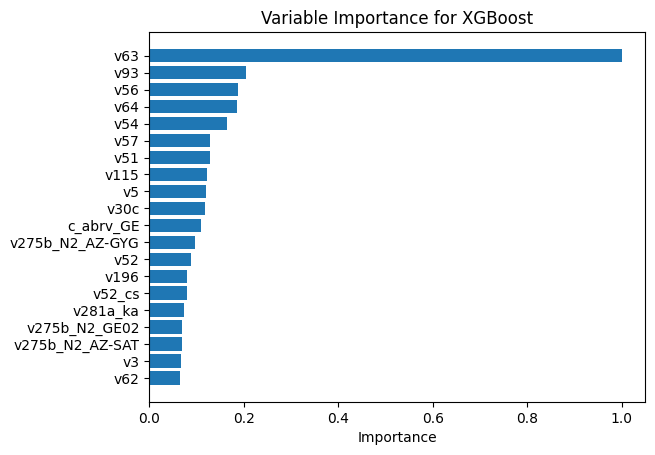

In [11]:
importance = best_model.feature_importances_

# Sort and standardize
names = dataset.getTrain().columns
max = importance.max()
standard_importance = [x / max for x in importance]
label = dict(sorted(zip(names, standard_importance),  key=lambda x: x[1])[-20:])

plt.barh(list(label.keys()), list(label.values()))
plt.xlabel("Importance")
plt.title("Variable Importance for XGBoost")
plt.show()